## Image inpainting
Based on [this paper](http://iizuka.cs.tsukuba.ac.jp/projects/completion/data/completion_sig2017.pdf)

### Import dependencies

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

### Setup

In [132]:
checkpoint_path = 'checkpoints/image_inpainting/image_inpainting.ckpt'

tqdm_callback = tfa.callbacks.TQDMProgressBar(
  show_epoch_progress=False
)

def conv2d_relu(filters, kernel, **kwargs):
  return [
    keras.layers.Conv2D(filters, kernel, **kwargs),
    keras.layers.ReLU()
  ]

def deconv2d_relu(filters, kernel, **kwargs):
  return [
    keras.layers.Conv2DTranspose(filters, kernel, **kwargs),
    keras.layers.ReLU()
  ]

### Generator model

In [135]:
generator_layers = list(plt.cbook.flatten([
  keras.layers.Input(shape=(1024, 1024, 3)),
  conv2d_relu(64, (5, 5), padding='same'),

  conv2d_relu(128, (3, 3), strides=(2, 2), padding='same', name='downscale_1'),
  conv2d_relu(128, (3, 3), padding='same'),

  conv2d_relu(256, (3, 3), strides=(2, 2), padding='same', name='downscale_2'),
  conv2d_relu(256, (3, 3), padding='same'),
  conv2d_relu(256, (3, 3), padding='same'),
  conv2d_relu(256, (3, 3), dilation_rate=2, padding='same', name='dilate_1'),
  conv2d_relu(256, (3, 3), dilation_rate=4, padding='same', name='dilate_2'),
  conv2d_relu(256, (3, 3), dilation_rate=8, padding='same', name='dilate_3'),
  conv2d_relu(256, (3, 3), dilation_rate=16, padding='same', name='dilate_4'),
  conv2d_relu(256, (3, 3), padding='same'),
  conv2d_relu(256, (3, 3), padding='same'),

  deconv2d_relu(128, (4, 4), strides=(2, 2), padding='same', name='upscale_1'),
  conv2d_relu(128, (3, 3), padding='same'),

  deconv2d_relu(64, (4, 4), strides=(2, 2), name='upscale_2'),
  conv2d_relu(32, (3, 3), padding='same'),
  keras.layers.Conv2D(3, (3, 3), activation=keras.activations.sigmoid)
]))
generator_model = keras.Sequential(layers=generator_layers, name='generator')
generator_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_633 (Conv2D)          (None, 1024, 1024, 64)    4864      
_________________________________________________________________
re_lu_64 (ReLU)              (None, 1024, 1024, 64)    0         
_________________________________________________________________
downscale_1 (Conv2D)         (None, 512, 512, 128)     73856     
_________________________________________________________________
re_lu_65 (ReLU)              (None, 512, 512, 128)     0         
_________________________________________________________________
conv2d_634 (Conv2D)          (None, 512, 512, 128)     147584    
_________________________________________________________________
re_lu_66 (ReLU)              (None, 512, 512, 128)     0         
_________________________________________________________________
downscale_2 (Conv2D)         (None, 256, 256, 256)     29

### Local discriminator model

In [139]:
local_discriminator_layers = list(plt.cbook.flatten([
  keras.layers.Input(shape=(128, 128, 3)),
  conv2d_relu(64, (5, 5), strides=(2, 2), padding='same'),
  conv2d_relu(128, (5, 5), strides=(2, 2), padding='same'),
  conv2d_relu(256, (5, 5), strides=(2, 2), padding='same'),
  conv2d_relu(512, (5, 5), strides=(2, 2), padding='same'),
  conv2d_relu(512, (5, 5), strides=(2, 2), padding='same'),

  keras.layers.Dense(units=1024)
]))
local_discriminator_model = keras.Sequential(layers=local_discriminator_layers, name='local_discriminator')
local_discriminator_model.summary()

Model: "local_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_657 (Conv2D)          (None, 64, 64, 64)        4864      
_________________________________________________________________
re_lu_91 (ReLU)              (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_658 (Conv2D)          (None, 32, 32, 128)       204928    
_________________________________________________________________
re_lu_92 (ReLU)              (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_659 (Conv2D)          (None, 16, 16, 256)       819456    
_________________________________________________________________
re_lu_93 (ReLU)              (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_660 (Conv2D)          (None, 8, 8, 512) 

### Concatenation layer

In [140]:
def concatenate_discriminator_values(x, y):
  return keras.layers.Dense(units=1, activation=keras.activations.sigmoid)(keras.layers.Concatenate([x, y]))

### Early testing of the generator

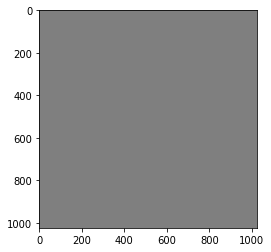

In [141]:
early_test_noise = tf.random.normal((1024, 1024, 3))
early_test_noise_tensor = tf.reshape(early_test_noise, (1, 1024, 1024, 3))

generated = generator_model(early_test_noise_tensor, training=False)
plt.imshow(generated[0])

### Generator loss

In [144]:
def generator_loss(fake_output):
  return keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

### Discriminator loss

In [145]:
def discriminator_loss(real_output, fake_output):
  cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

### Training

In [146]:
epochs = 50
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
  noise = tf.random.normal((16, 1024, 1024, 3))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_model(noise, training=True)